In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import svm, model_selection
from sklearn.model_selection import KFold

# this one is only needed if you want to use dictionary in getOptimalSMV
import operator

# use seaborn plotting defaults
import seaborn as sns 


sns.set()




In [11]:

# the function aims to visualize the input data X, colored according to labels Y, 
# superimposed over the decision boundary of the classifier clf
def plot_decision_boundary(clf, X, Y, cmap='Paired_r'):
    h = 0.02
    
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Assign the figure to var fig so we can save it later
    fig = plt.figure(figsize=(20,10))
    
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.7)
    plt.scatter(X[:,0], X[:,1], c=Y, cmap=cmap, edgecolors='k')

    #Labels and title of plot
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 1")
    plt.title("Plot of the two features ")
  
    plt.show()
    return fig

In [59]:
#Load Dataset
data = np.loadtxt('dataSVM.txt')

#Getting first 0.8 of dataset
#Training set
x_train = np.array(data[0:int(len(data) * 0.8), :-1])
y_train = np.array(data[0:int(len(data) * 0.8), 2])

#Getting last 0.2 of dataset
#Testing set
x_test = np.array(data[int(len(data) * 0.8):, :-1])
y_test = np.array(data[int(len(data) * 0.8):, 2])

#y_train = y_train.reshape(800,1)
#y_test = y_test.reshape(200,1)

N , features = (x_train.shape)
print(N , features)
print(y_train.shape)


print(x_test.shape)
print(y_test.shape)

800 2
(800,)
(200, 2)
(200,)


In [60]:
#what kernel to use for the SVM
#kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
svcKernel = 'linear'

#what gamma to use 
svcGamma = 'scale'
"""
    if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,

    if ‘auto’, uses 1 / n_features.
"""

"\n    if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,\n\n    if ‘auto’, uses 1 / n_features.\n"

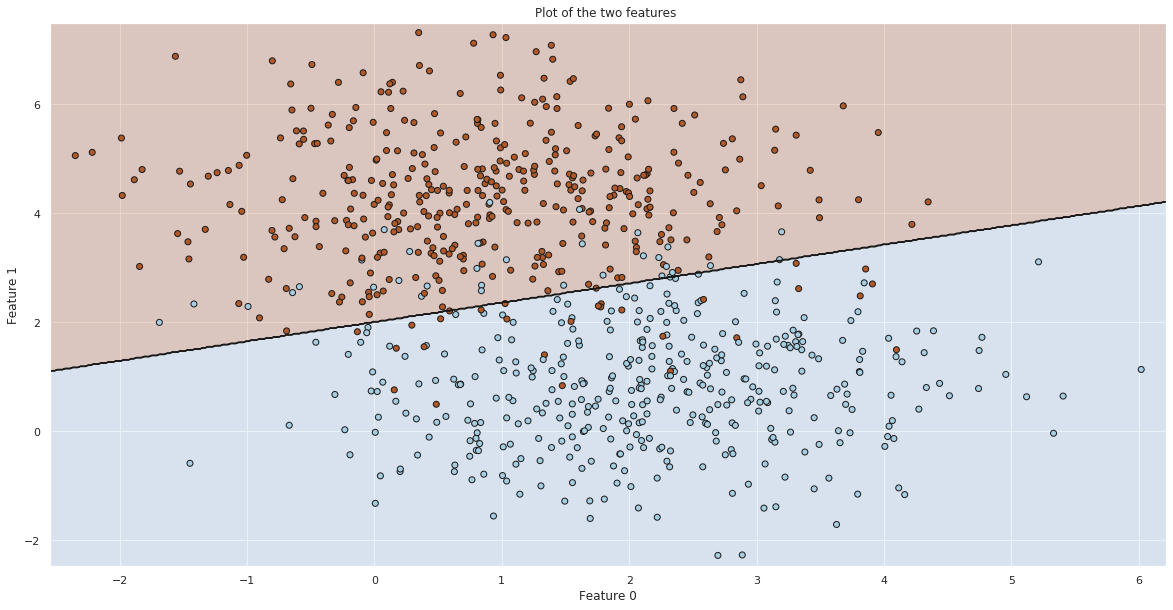

In [61]:
#Fitting the model to our training dataset 
clf = svm.SVC(kernel = svcKernel, C = 10, gamma=svcGamma)
clf.fit(x_train, y_train)
figure = plot_decision_boundary(clf, x_train, y_train)
figure.savefig("plot-"+str(clf)+".png")
plt.close()

In [96]:
class CrossValidation_SVM:
    
    def __init__(self, n_folds = 5, parameterCList = [0.001, 0.01, 0.1, 1, 10, 100]):
        """
        Initializes the model.
        
        Parameters
        ----------
        n_folds : the number of folds we expect to use for cross-validation
        """
        
        self.n_folds = n_folds
        self.parameterCList = parameterCList
    
    def __generateNextSplit(self, features, labels, kfold):
        """
        Use this function to generate next split of the input features and labels into 
        training and validation parts
        Parameters
        ----------
        features : Array of shape NxM
        labels   : Array of length N
        kfold    : iterator
        
        N is the number of samples, M is the number of features
        
        Returns
        -------
        trainingFeatures   : subportion of the features selected for training using the surrent split
        trainingLabels     : subportion of the labels selected for training using the surrent split
        validationFeatures : subportion of the features selected for validation using the surrent split
        validationLabels   : subportion of the labels selected for validation using the surrent split
        """ 
        
        train_index, validation_index = next(kfold.split(features))
        return features[train_index, :], labels[train_index], \
               features[validation_index, :], labels[validation_index], \
        #return trainingFeatures, trainingLabels, validationFeatures, validationLabels
    
    def computeErrorForSpecificC(self, features, labels, C):
        """
        Iterate throught all splits and compute the SVM performance using the specified C.
        Use linear kernel for svm.

        Parameters
        ----------
        features : Array of shape NxM
        labels   : Array of length N
        C : svm regularization parameter
        
        Returns
        -------
        meanAccuracy : mean validation accuracy computer over all splits
        """         
        
        accuracyArray = []
        
        # this function should use __generateNextSplit for iterating over splits
        
        # The iterator over folds. 
        kfold = KFold(self.n_folds, shuffle = False)
        for i in range(0, self.n_folds):
            trainingFeatures, trainingLabels, validationFeatures, validationLabels = \
                    self.__generateNextSplit(features, labels, kfold)
            #https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
            clf = svm.SVC(kernel = svcKernel, C = C, gamma = svcGamma)
            clf.fit(trainingFeatures, trainingLabels)
            results = clf.predict(validationFeatures)
            accuracyArray.append(np.mean(results == validationLabels))
        #print(np.mean(accuracyArray))
        return np.mean(accuracyArray)
    
    def getOptimalSMV(self, features, labels):
        """
        Iterate throught all C from self.parameterCList to find the optimal one

        Parameters
        ----------
        features : Array of shape NxM
        labels   : Array of length N
        Returns
        -------
        clf : the optimal SVM classfier trained on all input features and label
        accuracyList : the list of mean accuracies for each C from self.parameterCList.
                       accuracyList should be of the length len(self.parameterCList) 
        """
        
        accuracyList = {}# can use dictionary here: accuracyDict = {}
        for C in self.parameterCList:
            #go through all C in self.parameterCList using __computeErrorForSpecificC
            #save mean accuracyies in accuracyList for all C's
            accuracyList[C] = self.computeErrorForSpecificC(features, labels, C)
        
        #using dictionary
        #finding the C with the highest mean accuracy using max
        optC = max(accuracyList.items(), key=operator.itemgetter(1))[0]
        
        #linear kernel options are {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
        #train clf on all input features and label using the optimal C
        clf = svm.SVC(kernel = svcKernel, C = optC, gamma = svcGamma)
        
        clf.fit(features, labels)
        return clf, accuracyList
        

In [97]:
#this is the code to test our cross-validation implementation.
n_folds = 5
# parameterClist = basic error measure underlying the cross-validation error
# Create an instance of crossvalidation of the svm
tester = CrossValidation_SVM(n_folds = n_folds, parameterCList = [0.00001, 0.001, 0.01, 0.1, 1, 10, 100])
#Extract the clf and accuracies for  the training set
clf, accuracyList = tester.getOptimalSMV(x_train, y_train)
print(accuracyList)
print(clf)

#Fit the model to the training set with the optimal parameters
clf.fit(x_train,y_train)



{1e-05: 0.46875, 0.001: 0.925, 0.01: 0.925, 0.1: 0.93125, 1: 0.925, 10: 0.925, 100: 0.925}
SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [112]:
narrowParameterList = np.arange(0.02, 0.9, 0.02).tolist()
#print(narrowParameterList)
narrowTester = CrossValidation_SVM(n_folds = n_folds, parameterCList = narrowParameterList)

narrowClf , narrowAccuracyList = narrowTester.getOptimalSMV(x_train,y_train)
print(narrowAccuracyList)
print(narrowClf)

{0.02: 0.93125, 0.04: 0.925, 0.06: 0.925, 0.08: 0.925, 0.1: 0.93125, 0.12000000000000001: 0.91875, 0.13999999999999999: 0.91875, 0.16: 0.925, 0.18: 0.925, 0.19999999999999998: 0.925, 0.22: 0.925, 0.24: 0.925, 0.26: 0.925, 0.28: 0.925, 0.30000000000000004: 0.925, 0.32: 0.925, 0.34: 0.925, 0.36000000000000004: 0.925, 0.38: 0.925, 0.4: 0.925, 0.42000000000000004: 0.925, 0.44: 0.925, 0.46: 0.925, 0.48000000000000004: 0.925, 0.5: 0.925, 0.52: 0.925, 0.54: 0.925, 0.56: 0.925, 0.5800000000000001: 0.925, 0.6: 0.925, 0.62: 0.925, 0.64: 0.925, 0.66: 0.925, 0.68: 0.925, 0.7000000000000001: 0.925, 0.7200000000000001: 0.925, 0.74: 0.925, 0.76: 0.925, 0.78: 0.925, 0.8: 0.925, 0.8200000000000001: 0.925, 0.8400000000000001: 0.925, 0.86: 0.925, 0.88: 0.925}
SVC(C=0.02, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


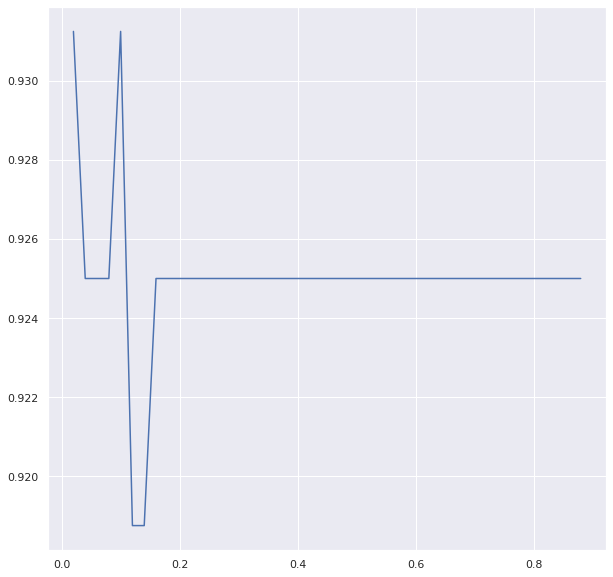

In [107]:
#x,y = zip(*narrowAccuracyList)
#plt.plot(narrowAccuracyList.items())
fig= plt.figure(figsize=(10,10))
x,y = zip(*sorted(narrowAccuracyList.items()))
plt.plot(x,y)
plt.show()
fig.savefig("narrowacc.png")

accuracy_score:
0.9


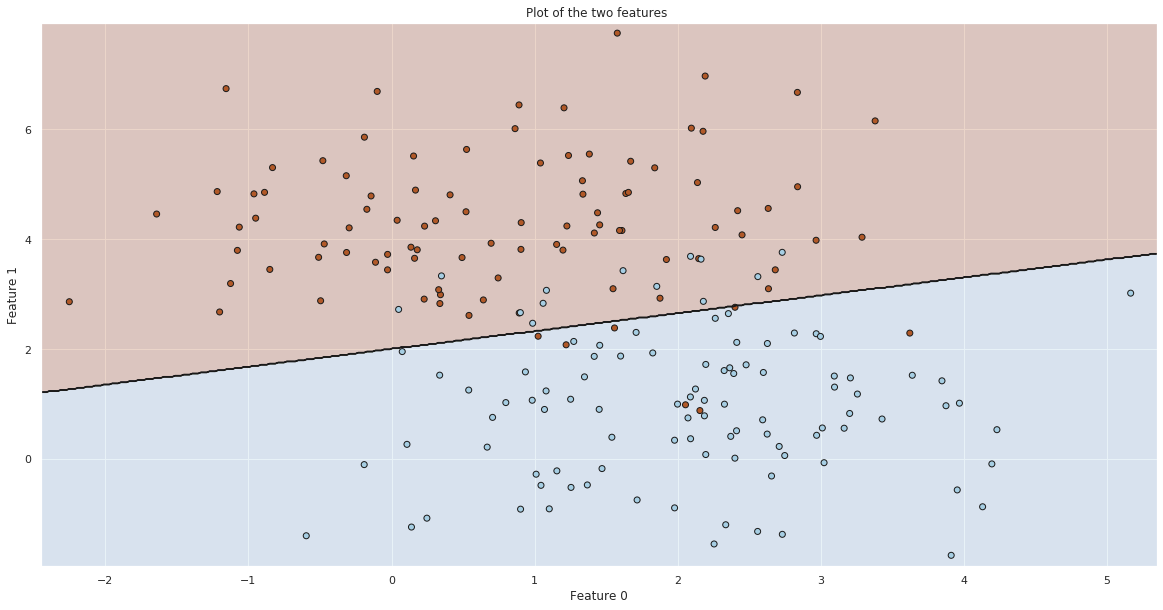

In [109]:
from sklearn.metrics import accuracy_score
#the maximal margin/boundary between the two classes
#Plot the decision boundary on the test set.
y_pred = narrowClf.predict(x_test)
print("accuracy_score:" )
print(accuracy_score(y_test,y_pred))

figure = plot_decision_boundary(narrowClf, x_test, y_test)
figure.savefig("plot-"+str(clf)+".png")

plt.close()

In [111]:
acc = narrowTester.computeErrorForSpecificC(x_test,y_test,C=0.02)
print(acc)

0.925
